In [11]:
from fredapi import Fred
import pandas as pd
import requests
import io
import datetime
import math
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import warnings
import os
warnings.filterwarnings("ignore")

In [12]:
# Use own API key 
fred_api_key = os.environ.get("FRED_TOKEN")

## Potential Project Goals

#### Predict number of months away from a recession
#### Predict % change in S&P 500
#### Predict if S&P 500 will drop by x% in the next year
#### Predict if a recession will occur in the next year

## Series and Codes

CPI - CPIAUCSL

% Change in CPI - use download link below

Median House Prices - MSPUS

Unemployment - UNRATE

Download Links:

https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=389&mode=fred&recession_bars=on&txtcolor=%23444444&ts=10&tts=10&width=536&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CPIAUCSL,CPILFESL&scale=left,left&cosd=1960-01-01,1960-01-01&coed=2022-05-01,2022-05-01&line_color=%234572a7,%23aa4643&link_values=false,false&line_style=solid,solid&mark_type=none,none&mw=1,1&lw=2,2&ost=-99999,-99999&oet=99999,99999&mma=0,0&fml=a,a&fq=Monthly,Monthly&fam=avg,avg&fgst=lin,lin&fgsnd=2009-06-01,2009-06-01&line_index=1,2&transformation=pc1,pc1&vintage_date=2022-06-27,2022-06-27&revision_date=2022-06-27,2022-06-27&nd=1947-01-01,1957-01-01

## Ideas Board
- Study time series models, would like to use trends
- add treasury yields, determine good indicators
- birthing rates
- potential predictors: 
    housing second deriv (housing_climb_change), 12 month change in unemployment rate, % change in CPI (cpi_change_all), years since recession
- potential targets: recession in next year, monthly/bimonthly pct change in s&p, years until recession

In [13]:
fred = Fred(api_key=fred_api_key)

## Pull Data and Clean

In [14]:
# Unemployment Rate
unemp = fred.get_series('UNRATE')
unemp = pd.DataFrame(unemp).reset_index()
unemp.columns = ['date', 'un_rate']
unemp.date = unemp.date.astype(str)
unemp = unemp[unemp['date'] >= '1965-01-01'].reset_index(drop=True)
using_dates = pd.DataFrame(unemp.date.values, columns=['date'])
unemp['12_mo_unemp_change'] = 0.
for i in range(12, len(unemp)):
    change = (unemp.at[i, 'un_rate'] - unemp.at[i-12, 'un_rate'])
    unemp.at[i, '12_mo_unemp_change'] = change
unemp = unemp[unemp['date'] >= '1968-01-01'].reset_index(drop=True)
unemp

,date,un_rate,12_mo_unemp_change
0,1968-01-01,3.7,-0.2
1,1968-02-01,3.8,0.0
2,1968-03-01,3.7,-0.1
3,1968-04-01,3.5,-0.3
4,1968-05-01,3.5,-0.3
...,...,...,...
648,2022-01-01,4.0,-2.4
649,2022-02-01,3.8,-2.4
650,2022-03-01,3.6,-2.4
651,2022-04-01,3.6,-2.4


In [15]:
# Median Household Prices
mhp = fred.get_series('MSPUS')
mhp = pd.DataFrame(mhp).reset_index()
mhp.columns = ['date', 'median_household_price']
mhp.date = mhp.date.astype(str)
mhp = mhp.merge(using_dates, how='right', on='date')
mhp.median_household_price = mhp.median_household_price.fillna(method='pad')
mhp['pct_house_change_year'] = 0.
mhp['housing_climb_change'] = 0.
for i in range(12, len(mhp)):
    pct_change = ((mhp.at[i, 'median_household_price'] - 
                   mhp.at[i-12, 'median_household_price']) /
                mhp.at[i-12, 'median_household_price']) * 100
    mhp.at[i, 'pct_house_change_year'] = pct_change
    
    value_change = (mhp.at[i, 'pct_house_change_year'] - mhp.at[i-12, 'pct_house_change_year'])
    mhp.at[i, 'housing_climb_change'] = value_change

mhp = mhp[mhp['date'] >= '1968-01-01'].reset_index(drop=True)
mhp

,date,median_household_price,pct_house_change_year,housing_climb_change
0,1968-01-01,23900.0,7.174888,0.984412
1,1968-02-01,23900.0,7.174888,0.984412
2,1968-03-01,23900.0,7.174888,0.984412
3,1968-04-01,24900.0,6.866953,1.437089
4,1968-05-01,24900.0,6.866953,1.437089
...,...,...,...,...
648,2022-01-01,428700.0,15.927528,3.526313
649,2022-02-01,428700.0,15.927528,3.526313
650,2022-03-01,428700.0,15.927528,3.526313
651,2022-04-01,428700.0,12.049137,-6.549747


In [16]:
# % Change in CPI
latest_date = datetime.datetime.today() - datetime.timedelta(1)
ld_string = latest_date.strftime('%Y-%m-%d')
latest_month = datetime.datetime(2022, datetime.datetime.today().month - 1, 1)
lm_string = latest_month.strftime('%Y-%m-%d')
cpi = requests.get('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&' + 
                   'chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&heigh' + 
                   't=389&mode=fred&recession_bars=on&txtcolor=%23444444&ts=10&tts=10&' + 
                   'width=536&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&sh' + 
                   'ow_tooltip=yes&id=CPIAUCSL,CPILFESL&scale=left,left&cosd=1960-01-0' + 
                   '1,1960-01-01&coed=' + lm_string + ',' + lm_string + '&line_color=%' + 
                   '234572a7,%23aa4643&link_values=false,false&line_style=solid,solid&' + 
                   'mark_type=none,none&mw=1,1&lw=2,2&ost=-99999,-99999&oet=99999,9999' + 
                   '9&mma=0,0&fml=a,a&fq=Monthly,Monthly&fam=avg,avg&fgst=lin,lin&fgsn' + 
                   'd=2009-06-01,2009-06-01&line_index=1,2&transformation=pc1,pc1&vint' + 
                   'age_date=' + ld_string + ',' + ld_string + '&revision_date=' + 
                   ld_string + ',' + ld_string + '&nd=1947-01-01,1957-01-01')
cpi = pd.read_csv(io.StringIO(cpi.content.decode('utf-8')))
cpi.columns = ['date', 'cpi_change_all', 'cpi_change_less_food_and_energy']
cpi['36_mo_cpi_change_all'] = 0.
for i in range(36, len(cpi)):
    change = (cpi.at[i, 'cpi_change_all'] - cpi.at[i-36, 'cpi_change_all'])
    cpi.at[i, '36_mo_cpi_change_all'] = change

cpi = cpi[cpi['date'] >= '1968-01-01'].reset_index(drop=True)
cpi

,date,cpi_change_all,cpi_change_less_food_and_energy,36_mo_cpi_change_all
0,1968-01-01,3.64742,3.80117,2.54852
1,1968-02-01,3.63636,4.38596,2.43934
2,1968-03-01,3.93939,4.37318,2.74353
3,1968-04-01,3.92749,4.36047,2.53815
4,1968-05-01,4.22961,4.34783,2.61567
...,...,...,...,...
648,2022-01-01,7.52593,6.04078,6.02760
649,2022-02-01,7.91202,6.41574,6.43030
650,2022-03-01,8.55759,6.43604,6.67764
651,2022-04-01,8.22414,6.13369,6.21851


In [17]:
# S&P500 data
# Source: S&P 500 Historical Prices by Month, multpl.com

from bs4 import BeautifulSoup

url = 'https://www.multpl.com/s-p-500-historical-prices/table/by-month'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find(id='datatable')

sp = pd.DataFrame(columns = ['date', 'average_sp_price'])

dt = table.find_all('tr')
for i in range(2, len(dt)):
    info = dt[i].find_all('td')
    date = info[0].text
    date = datetime.datetime.strptime(date, '%b %d, %Y').strftime('%Y-%m-%d')
    price = info[1].text[:info[1].text.index('\n')].replace(',', '')
    sp = sp.append({'date': date, 'average_sp_price': float(price)}, ignore_index=True)

sp['pct_monthly_sp_change'] = 0.
sp['pct_bimonthly_sp_change'] = 0.
sp = sp[sp['date'] >= '1967-01-01']
sp = sp.sort_values('date').reset_index(drop=True)
for i in range(2, len(sp)):
    monthly_pct_change = ((sp.at[i, 'average_sp_price'] - 
                   sp.at[i-1, 'average_sp_price']) /
                sp.at[i-1, 'average_sp_price']) * 100
    sp.at[i, 'pct_monthly_sp_change'] = monthly_pct_change
    
    bi_pct_change = ((sp.at[i, 'average_sp_price'] - 
                   sp.at[i-2, 'average_sp_price']) /
                sp.at[i-2, 'average_sp_price']) * 100
    sp.at[i, 'pct_bimonthly_sp_change'] = bi_pct_change
    
sp = sp[sp['date'] >= '1968-01-01'].reset_index(drop=True)
sp

,date,average_sp_price,pct_monthly_sp_change,pct_bimonthly_sp_change
0,1968-01-01,95.04,-0.272823,2.568530
1,1968-02-01,90.75,-4.513889,-4.774397
2,1968-03-01,89.09,-1.829201,-6.260522
3,1968-04-01,95.67,7.385790,5.421488
4,1968-05-01,97.87,2.299571,9.855203
...,...,...,...,...
649,2022-02-01,4435.98,-3.013673,-5.108059
650,2022-03-01,4391.27,-1.007895,-3.991193
651,2022-04-01,4391.30,0.000683,-1.007218
652,2022-05-01,4040.36,-7.991711,-7.991082


In [18]:
# Federal Yield Rates

# 10 Year Yeld 
yield_ten = fred.get_series('DGS10')
yield_ten = pd.DataFrame(yield_ten).reset_index()
yield_ten.columns = ['date', 'ten_yr_yield']
yield_ten.date = [pd.to_datetime(x).strftime('%Y-%m-%d') for x in yield_ten.date.values]
yield_ten = yield_ten.merge(using_dates, how = 'outer', on='date').sort_values('date')
yield_ten.ten_yr_yield = yield_ten.ten_yr_yield.fillna(method='bfill').fillna(method='ffill')
rows = [(x, y) for x, y 
        in zip(yield_ten.date.values, yield_ten.ten_yr_yield.values) if
                (x.split('-')[2] == '01')]
dates = [r[0] for r in rows]
rates = [r[1] for r in rows]
yield_ten = pd.DataFrame(data=rows, columns = ['date', 'ten_yr_yield'])

# 1 Year Yield
yield_one = fred.get_series('DGS1')
yield_one = pd.DataFrame(yield_one).reset_index()
yield_one.columns = ['date', 'one_yr_yield']
yield_one.date = [pd.to_datetime(x).strftime('%Y-%m-%d') for x in yield_one.date.values]
yield_one = yield_one.merge(using_dates, how = 'outer', on='date').sort_values('date')
yield_one.one_yr_yield = yield_one.one_yr_yield.fillna(method='bfill').fillna(method='ffill')
rows = [(x, y) for x, y 
        in zip(yield_one.date.values, yield_one.one_yr_yield.values) if
                (x.split('-')[2] == '01')]
dates = [r[0] for r in rows]
rates = [r[1] for r in rows]
yield_one = pd.DataFrame(data=rows, columns = ['date', 'one_yr_yield'])

total_yield = yield_ten.merge(yield_one, how = 'inner', on='date')
total_yield['yield_diff'] = total_yield['ten_yr_yield'] - total_yield['one_yr_yield']
total_yield['yield_below_zero'] = (total_yield['yield_diff'] < 0).astype(int)
total_yield

,date,ten_yr_yield,one_yr_yield,yield_diff,yield_below_zero
0,1962-02-01,4.09,3.30,0.79,0
1,1962-03-01,3.98,3.15,0.83,0
2,1962-05-01,3.85,3.06,0.79,0
3,1962-06-01,3.89,2.98,0.91,0
4,1962-08-01,4.03,3.30,0.73,0
...,...,...,...,...,...
709,2022-02-01,1.81,0.78,1.03,0
710,2022-03-01,1.72,0.91,0.81,0
711,2022-04-01,2.39,1.72,0.67,0
712,2022-05-01,2.99,2.10,0.89,0


## Merge Data

In [19]:
# Merge all of the data together. This will become the foundation for the model and analysis
total_data = unemp.merge(mhp, how='outer', on='date')
total_data = total_data.merge(cpi, how='outer', on='date')
total_data = total_data.merge(sp, how='left', on='date')
total_data = total_data.merge(total_yield, how='left', on='date')
total_data

,date,un_rate,12_mo_unemp_change,median_household_price,pct_house_change_year,housing_climb_change,cpi_change_all,cpi_change_less_food_and_energy,36_mo_cpi_change_all,average_sp_price,pct_monthly_sp_change,pct_bimonthly_sp_change,ten_yr_yield,one_yr_yield,yield_diff,yield_below_zero
0,1968-01-01,3.7,-0.2,23900.0,7.174888,0.984412,3.64742,3.80117,2.54852,95.04,-0.272823,2.568530,5.63,5.71,-0.08,1
1,1968-02-01,3.8,0.0,23900.0,7.174888,0.984412,3.63636,4.38596,2.43934,90.75,-4.513889,-4.774397,5.58,5.37,0.21,0
2,1968-03-01,3.7,-0.1,23900.0,7.174888,0.984412,3.93939,4.37318,2.74353,89.09,-1.829201,-6.260522,5.56,5.43,0.13,0
3,1968-04-01,3.5,-0.3,24900.0,6.866953,1.437089,3.92749,4.36047,2.53815,95.67,7.385790,5.421488,5.64,5.54,0.10,0
4,1968-05-01,3.5,-0.3,24900.0,6.866953,1.437089,4.22961,4.34783,2.61567,97.87,2.299571,9.855203,5.73,6.00,-0.27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,2022-01-01,4.0,-2.4,428700.0,15.927528,3.526313,7.52593,6.04078,6.02760,4573.82,-2.159465,-2.004761,1.63,0.40,1.23,0
649,2022-02-01,3.8,-2.4,428700.0,15.927528,3.526313,7.91202,6.41574,6.43030,4435.98,-3.013673,-5.108059,1.81,0.78,1.03,0
650,2022-03-01,3.6,-2.4,428700.0,15.927528,3.526313,8.55759,6.43604,6.67764,4391.27,-1.007895,-3.991193,1.72,0.91,0.81,0
651,2022-04-01,3.6,-2.4,428700.0,12.049137,-6.549747,8.22414,6.13369,6.21851,4391.30,0.000683,-1.007218,2.39,1.72,0.67,0


## Create Methods to Fill Target Variables

In [20]:
recession_starts = ['1960-04-01', '1969-12-01', '1973-11-01', '1980-01-01', '1981-07-01', 
                    '1990-07-01', '2001-03-01', '2007-12-01', '2020-02-01']
recession_ends = ['1961-02-01', '1970-11-01', '1975-03-01', '1980-07-01', '1982-11-01', 
                  '1991-03-01', '2001-11-01', '2009-06-01', '2020-04-01']

In [21]:
# returns the number of years from the given date since the last recession
# returns 0 if date is during a recession
# returns NaN if given date is before the earliest recorded recesssion in the data
def yearsSinceRecession(date):
    if date < recession_starts[0]:
        return float('NaN')
    days_since_list = []
    for i in range(len(recession_ends)):
        days_since = (datetime.datetime.strptime(date, '%Y-%m-%d') - 
                      datetime.datetime.strptime(recession_ends[i], '%Y-%m-%d')).days
        days_since_list.append(days_since)
    min_days = min(d for d in days_since_list if d > 0)
    min_days_idx = days_since_list.index(min_days)
    if min_days_idx == len(recession_starts) - 1:
        return min_days / 365
    elif date >= recession_starts[min_days_idx + 1]:
        return 0
    else:
        return min_days / 365

In [22]:
# returns the number of years from the given date until the next recession
# returns 0 if date is in a recession
# returns nan if date is after the latest recession
def yearsUntilRecession(date):
    days_until_list = []
    for i in range(len(recession_starts)):
        days_until = (datetime.datetime.strptime(recession_starts[i], '%Y-%m-%d') - 
                      datetime.datetime.strptime(date, '%Y-%m-%d')).days
        days_until_list.append(days_until)
    try:
        min_days = min(d for d in days_until_list if d >= 0)
    except ValueError as e:
        if date <= recession_ends[-1]:
            return 0
        return float('NaN')
    min_days_idx = days_until_list.index(min_days)
    if (min_days_idx != 0) & (date <= recession_ends[min_days_idx - 1]):
        return 0
    else:
        return min_days / 365

In [23]:
# returns 1 if there is a recession in the next year, or if there is currently a recession
# returns NaN if one year from the listed date is in the future
# returns 0 otherwise
def recessionInNextYear(date):
    if yearsSinceRecession(date) == 0:
        return 1
    
    split_date = date.split('-')
    one_year_later = str(int(split_date[0]) + 1) + '-' + split_date[1] + '-' + split_date[2]
    if one_year_later > datetime.datetime.today().strftime('%Y-%m-%d'):
        return float('NaN')
    possible_matches = [d for d in recession_starts if d >= date]
    possible_matches = [d for d in possible_matches if d <= one_year_later]
    return float(len(possible_matches) > 0)

In [24]:
def inRecession(date):
    for i in range(len(recession_starts)):
        if (date <= recession_ends[i]) & (date >= recession_starts[i]):
            return 1
    return 0

In [25]:
YSRVect = np.vectorize(yearsSinceRecession)
YURVect = np.vectorize(yearsUntilRecession)
RINYVect = np.vectorize(recessionInNextYear)
IRVect = np.vectorize(inRecession)

In [26]:
total_data['years_since_recession'] = YSRVect(total_data.date.values)
total_data['years_until_recession'] = YURVect(total_data.date.values)
total_data['recession_in_next_year'] = RINYVect(total_data.date.values)
total_data['in_recession'] = IRVect(total_data.date.values)
total_data

,date,un_rate,12_mo_unemp_change,median_household_price,pct_house_change_year,housing_climb_change,cpi_change_all,cpi_change_less_food_and_energy,36_mo_cpi_change_all,average_sp_price,pct_monthly_sp_change,pct_bimonthly_sp_change,ten_yr_yield,one_yr_yield,yield_diff,yield_below_zero,years_since_recession,years_until_recession,recession_in_next_year,in_recession
0,1968-01-01,3.7,-0.2,23900.0,7.174888,0.984412,3.64742,3.80117,2.54852,95.04,-0.272823,2.568530,5.63,5.71,-0.08,1,6.917808,1.917808,0.0,0
1,1968-02-01,3.8,0.0,23900.0,7.174888,0.984412,3.63636,4.38596,2.43934,90.75,-4.513889,-4.774397,5.58,5.37,0.21,0,7.002740,1.832877,0.0,0
2,1968-03-01,3.7,-0.1,23900.0,7.174888,0.984412,3.93939,4.37318,2.74353,89.09,-1.829201,-6.260522,5.56,5.43,0.13,0,7.082192,1.753425,0.0,0
3,1968-04-01,3.5,-0.3,24900.0,6.866953,1.437089,3.92749,4.36047,2.53815,95.67,7.385790,5.421488,5.64,5.54,0.10,0,7.167123,1.668493,0.0,0
4,1968-05-01,3.5,-0.3,24900.0,6.866953,1.437089,4.22961,4.34783,2.61567,97.87,2.299571,9.855203,5.73,6.00,-0.27,1,7.249315,1.586301,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,2022-01-01,4.0,-2.4,428700.0,15.927528,3.526313,7.52593,6.04078,6.02760,4573.82,-2.159465,-2.004761,1.63,0.40,1.23,0,1.753425,NaN,NaN,0
649,2022-02-01,3.8,-2.4,428700.0,15.927528,3.526313,7.91202,6.41574,6.43030,4435.98,-3.013673,-5.108059,1.81,0.78,1.03,0,1.838356,NaN,NaN,0
650,2022-03-01,3.6,-2.4,428700.0,15.927528,3.526313,8.55759,6.43604,6.67764,4391.27,-1.007895,-3.991193,1.72,0.91,0.81,0,1.915068,NaN,NaN,0
651,2022-04-01,3.6,-2.4,428700.0,12.049137,-6.549747,8.22414,6.13369,6.21851,4391.30,0.000683,-1.007218,2.39,1.72,0.67,0,2.000000,NaN,NaN,0


In [27]:
def makePlot(y, x='date', start_date='1968-01-01', end_date=datetime.datetime.today().strftime('%Y-%m-%d'), 
             df=total_data, horiz_line_height=0):
    subdata = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    fig, ax = plt.subplots(1,1,figsize=(25,25))
    for variable in y:
        sns.lineplot(data=subdata, x=x, y=variable, ax=ax)
    
    # Shade the regions during a recession
    if x == 'date':
        line = ax.get_lines()[-1]
        x_mask, y_mask = line.get_data()
        mask = IRVect(x_mask)
        switch_list = []
        for i in range(len(mask)):
            if (((i == 0) & (mask[i] == 1)) | 
                ((i != 0) & (mask[i] != mask[i-1])) | 
                ((i == len(mask) - 1) & (mask[i] == 1))):
                switch_list.append(i)
        
        it = 0
        while it < len(switch_list):
            plt.axvspan(switch_list[it], switch_list[it + 1], color='gray', alpha=0.5, lw=0)
            plt.axvspan(switch_list[it], switch_list[it] - 12, color='yellow', alpha=0.3, lw=0)
            it += 2
    
    plt.axhline(y=horiz_line_height, color='black', linestyle='--')
    ax.legend(labels=y+['', 'recession', 'year before recession'])
    plt.show()

TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'str'

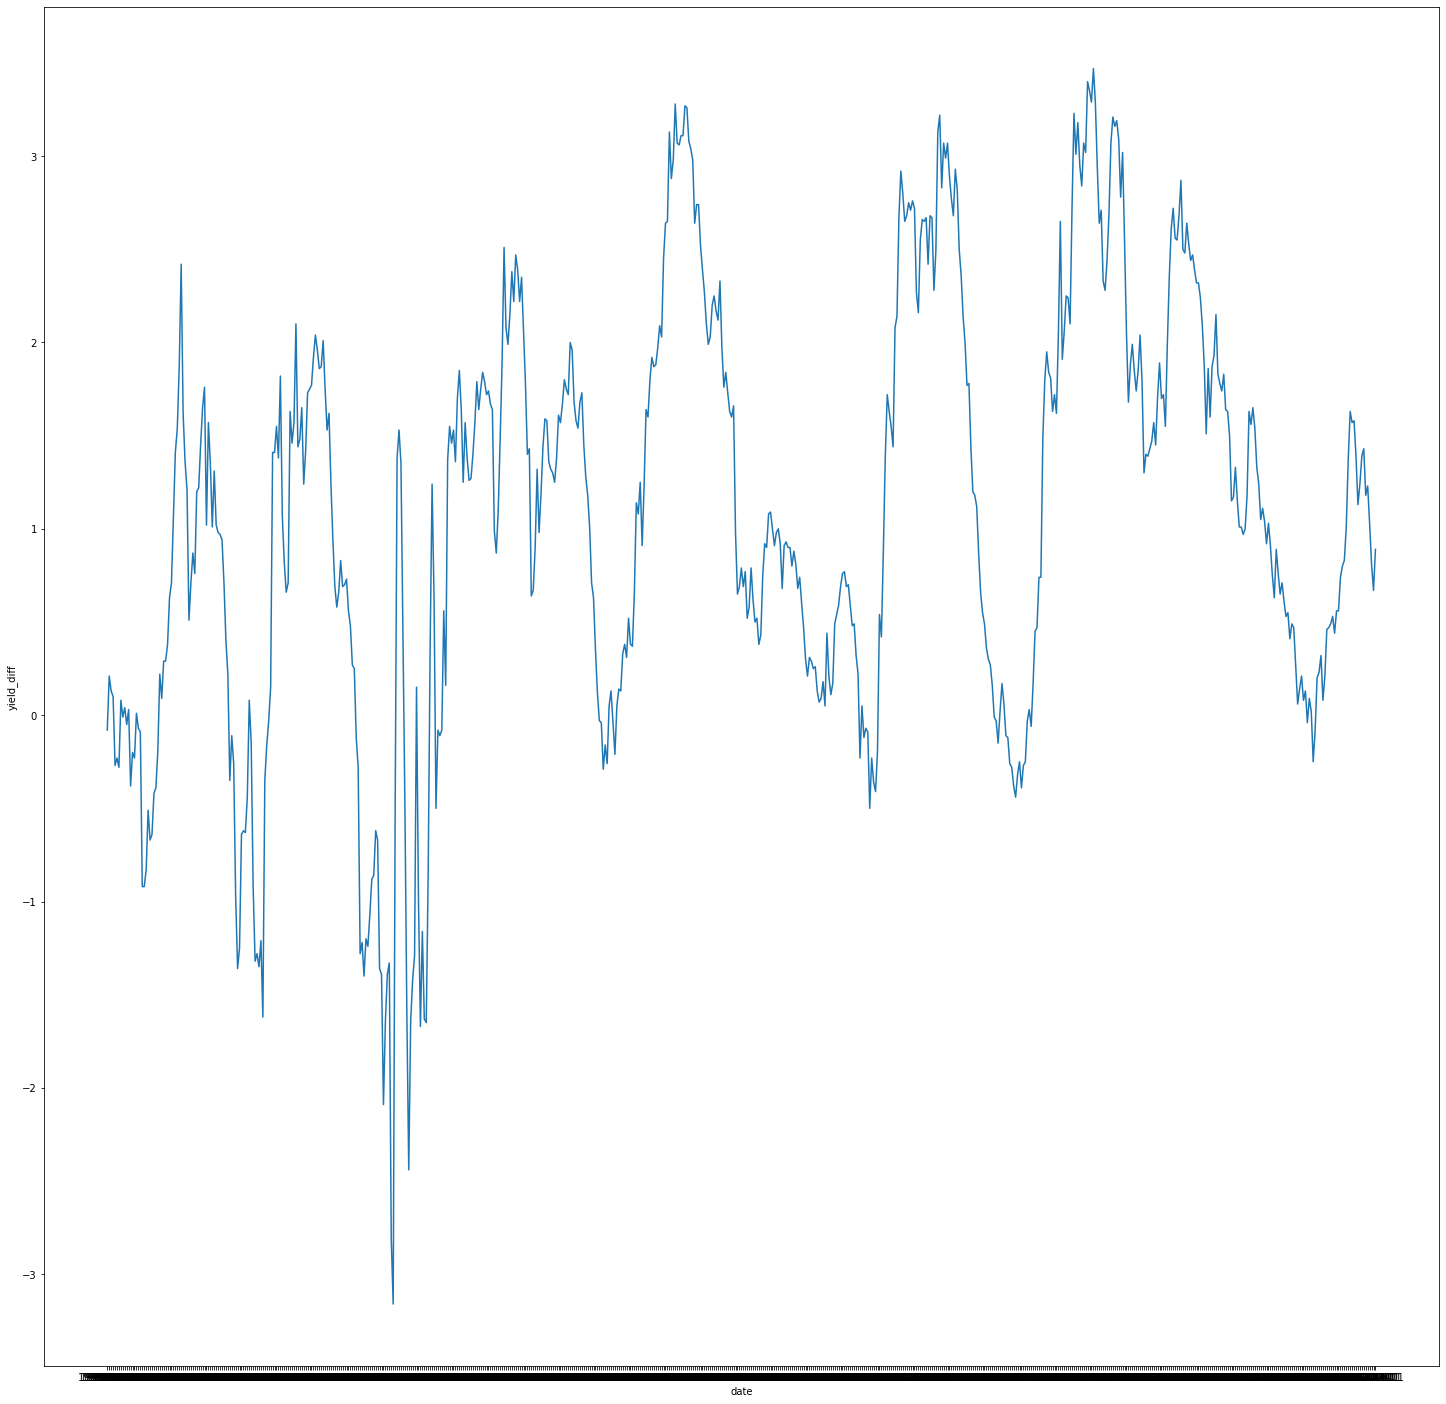

In [28]:
makePlot(['yield_diff'])

# Building the Models

In [29]:
# import machine learning packages
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics
from scipy.stats import norm
from scipy.stats import ttest_ind

In [30]:
# Creates a histogram to show the distribution of data for a given feature among different labels
def histPlot(feature, binary):
    cropped_data = total_data[total_data['in_recession'] == 0]
    fig, ax = plt.subplots(1,1)
    ax.hist(cropped_data[cropped_data[binary]==1][feature], alpha=0.5, label='Recession')
    ax.hist(cropped_data[cropped_data[binary]==0][feature], alpha=0.5, label='No Recession')
    ax.legend()
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of ' + feature.replace('_', ' ').title() + ' by ' + binary.replace('_', ' ').title())
    plt.show()

In [31]:
# Creates a histogram to show the distribution of data for a given feature among a dependent variable
def scatPlot(feature, dependent):
    cropped_data = total_data[total_data['in_recession'] == 0]
    fig, ax = plt.subplots(1,1)
    ax.scatter(x=cropped_data[feature], y=cropped_data[dependent])
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel(dependent.replace('_', ' ').title())
    ax.set_title('Distribution of ' + feature.replace('_', ' ').title() + ' by ' + dependent.replace('_', ' ').title())
    plt.show()

## Predicting Recession in Next Year (RINY)
### Logistic Regression

In [32]:
total_data.columns

Index(['date', 'un_rate', '12_mo_unemp_change', 'median_household_price',
       'pct_house_change_year', 'housing_climb_change', 'cpi_change_all',
       'cpi_change_less_food_and_energy', '36_mo_cpi_change_all',
       'average_sp_price', 'pct_monthly_sp_change', 'pct_bimonthly_sp_change',
       'ten_yr_yield', 'one_yr_yield', 'yield_diff', 'yield_below_zero',
       'years_since_recession', 'years_until_recession',
       'recession_in_next_year', 'in_recession'],
      dtype='object')

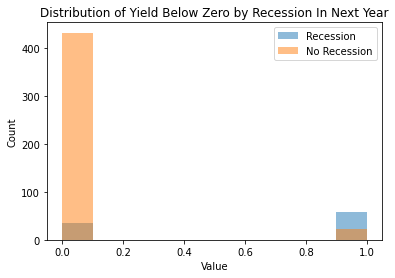

In [33]:
histPlot('yield_below_zero', 'recession_in_next_year')

In [34]:
# Create base for the Recession in Next Year (RINY) model

riny_columns = ['date', 'housing_climb_change', '36_mo_cpi_change_all',
       'yield_diff', 'yield_below_zero', 'years_since_recession', 'years_until_recession',
       'recession_in_next_year']

riny_df = total_data[(total_data['in_recession'] == 0) & (~total_data['years_until_recession'].isnull())]
riny_df = riny_df[riny_columns]

sig_features = []
non_sig_features = []

for feature in riny_df.loc[:, ~riny_df.columns.isin(['date', 'recession_in_next_year', 'years_until_recession'])].columns:
    test_sample1 = riny_df[riny_df['recession_in_next_year'] == 1][feature]
    test_sample2 = riny_df[riny_df['recession_in_next_year'] == 0][feature]
    t_stat = ttest_ind(test_sample1, test_sample2, equal_var=False)
    if t_stat.pvalue < 0.05:
        sig_features.append(feature)
    else:
        non_sig_features.append(feature)

print('Significant: ', sig_features)
print('\nNot Significant: ', non_sig_features)

Significant:  ['housing_climb_change', '36_mo_cpi_change_all', 'yield_diff', 'yield_below_zero', 'years_since_recession']

Not Significant:  []


In [35]:
# Plot covariance of features
pd.DataFrame.cov(riny_df[sig_features])

,housing_climb_change,36_mo_cpi_change_all,yield_diff,yield_below_zero,years_since_recession
housing_climb_change,39.368297,-2.751325,1.093020,-0.224663,-4.918660
36_mo_cpi_change_all,-2.751325,8.249965,-1.474027,0.410397,2.464969
yield_diff,1.093020,-1.474027,1.283823,-0.267134,-1.612303
yield_below_zero,-0.224663,0.410397,-0.267134,0.130022,0.223063
years_since_recession,-4.918660,2.464969,-1.612303,0.223063,7.855777


In [36]:
# Create X (features) and y (value) sets
X = riny_df.loc[:, riny_df.columns.isin(sig_features)]
y = riny_df.loc[:, riny_df.columns == 'recession_in_next_year']
X

,housing_climb_change,36_mo_cpi_change_all,yield_diff,yield_below_zero,years_since_recession
0,0.984412,2.54852,-0.08,1,6.917808
1,0.984412,2.43934,0.21,0,7.002740
2,0.984412,2.74353,0.13,0,7.082192
3,1.437089,2.53815,0.10,0,7.167123
4,1.437089,2.61567,-0.27,1,7.249315
...,...,...,...,...,...
620,-7.022506,0.17869,-0.25,1,10.257534
621,5.800872,0.07116,-0.08,1,10.339726
622,5.800872,0.34649,0.20,0,10.424658
623,5.800872,0.21092,0.23,0,10.506849


In [37]:
# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Standardize variables to create consistent scaling
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
X_scaled = pd.DataFrame(data=X_scaled, columns=X_train.columns)

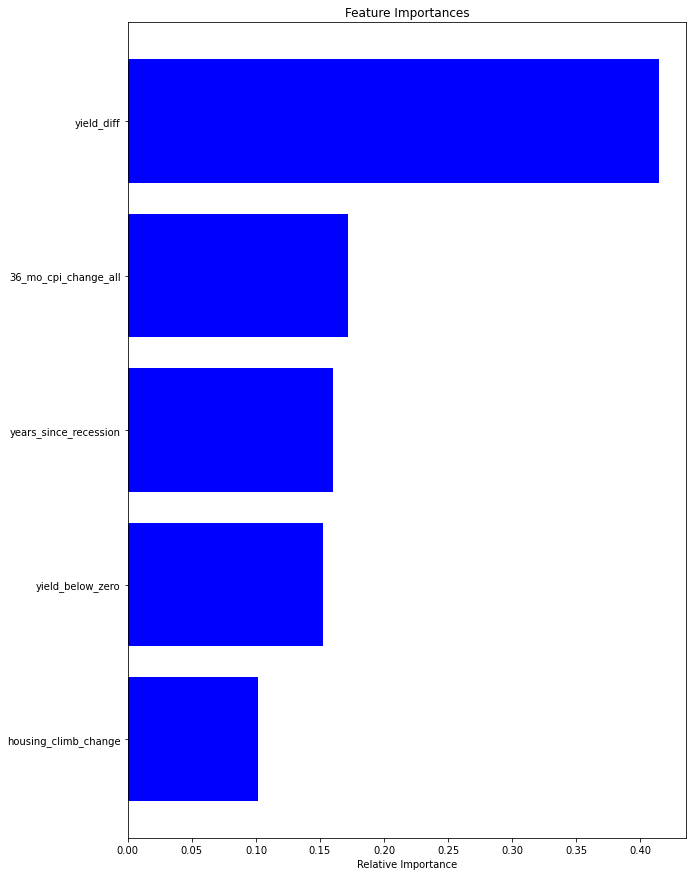

In [38]:
# Use Random Forest Classifier to Determine features that may be most important to the model
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rfc.fit(X_train, y_train)

importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [sig_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [39]:
# Preliminary score of model
rfc.score(X_test, y_test)

0.9503105590062112

In [40]:
# Fit the model
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [41]:
# Print coefficients for the model (based on standardized variables)
coefs_df = pd.DataFrame()
coefs_df['Feature'] = logreg.feature_names_in_
coefs_df['Coefficient'] = logreg.coef_[0]
coefs_df.reindex(coefs_df.Coefficient.abs().sort_values(ascending=False).index)

,Feature,Coefficient
2,yield_diff,-3.154085
1,36_mo_cpi_change_all,0.408403
0,housing_climb_change,0.083309
3,yield_below_zero,-0.025348
4,years_since_recession,-0.014215


In [42]:
# Score the model on the test data
y_pred = logreg.predict(scaler.transform(X_test))
print('Test Accuracy: ', round(logreg.score(scaler.transform(X_test), y_test), 3))

# Score the model on the train data
print('Train Accuracy: ', round(logreg.score(X_scaled, y_train),3))

Test Accuracy:  0.851
Train Accuracy:  0.872


In [43]:
# Create a Confusion Matrix to Represent Test Data
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print('--Confusion Matrix--')
print('True Positives: ', tp)
print('False Positives: ', fp)
print('True Negatives: ', tn)
print('False Negaties: ', fn)

--Confusion Matrix--
True Positives:  23
False Positives:  24
True Negatives:  114
False Negaties:  0


In [44]:
# Test data only
# When the model predicts a recession and is wrong, how soon is the recession really
# When the model predicts a recession at all, how soon is the recession
# Not added to methods
analysis_df = total_data.filter(items = list(X_test.index), axis=0)
analysis_df['riny_pred'] = logreg.predict(scaler.transform(analysis_df[sig_features]))
print('False positive median time: ', 
      analysis_df[(analysis_df['riny_pred'] == 1) & (analysis_df['recession_in_next_year'] == 0)].years_until_recession.median())
print('False positive average time: ', 
      analysis_df[(analysis_df['riny_pred'] == 1) & (analysis_df['recession_in_next_year'] == 0)].years_until_recession.mean())
print('Positive prediction median time: ', 
      analysis_df[(analysis_df['riny_pred'] == 1)].years_until_recession.median())
print('Positive prediction average time: ', 
      analysis_df[(analysis_df['riny_pred'] == 1)].years_until_recession.mean())


False positive median time:  1.8342465753424657
False positive average time:  2.02134703196347
Positive prediction median time:  1.0794520547945206
Positive prediction average time:  1.2697172835907897


In [45]:
# Predictions for the most recent year
present_data = total_data[(total_data['recession_in_next_year'].isnull())]
present_data['riny_pred_bin'] = logreg.predict(scaler.transform(present_data[sig_features]))
prob_preds = logreg.predict_proba(scaler.transform(present_data[sig_features]))
present_data['riny_pred_prob'] = [pred[1] for pred in prob_preds]
present_data

,date,un_rate,12_mo_unemp_change,median_household_price,pct_house_change_year,housing_climb_change,cpi_change_all,cpi_change_less_food_and_energy,36_mo_cpi_change_all,average_sp_price,...,ten_yr_yield,one_yr_yield,yield_diff,yield_below_zero,years_since_recession,years_until_recession,recession_in_next_year,in_recession,riny_pred_bin,riny_pred_prob
643,2021-08-01,5.2,-3.2,411200.0,21.837037,15.838293,5.20533,3.96186,2.52733,4454.21,...,1.20,0.07,1.13,0,1.334247,NaN,NaN,0,0.0,0.230440
644,2021-09-01,4.7,-3.2,411200.0,21.837037,15.838293,5.38991,4.03675,3.03473,4445.54,...,1.31,0.07,1.24,0,1.419178,NaN,NaN,0,0.0,0.192714
645,2021-10-01,4.6,-2.3,423600.0,18.093114,8.432460,6.23694,4.59396,3.70842,4460.71,...,1.48,0.09,1.39,0,1.501370,NaN,NaN,0,0.0,0.136945
646,2021-11-01,4.2,-2.5,423600.0,18.093114,8.432460,6.82837,4.95263,4.65556,4667.39,...,1.58,0.15,1.43,0,1.586301,NaN,NaN,0,0.0,0.139325
647,2021-12-01,3.9,-2.8,423600.0,18.093114,8.432460,7.09654,5.47662,5.18132,4674.77,...,1.43,0.25,1.18,0,1.668493,NaN,NaN,0,0.0,0.253289
648,2022-01-01,4.0,-2.4,428700.0,15.927528,3.526313,7.52593,6.04078,6.02760,4573.82,...,1.63,0.40,1.23,0,1.753425,NaN,NaN,0,0.0,0.237611
649,2022-02-01,3.8,-2.4,428700.0,15.927528,3.526313,7.91202,6.41574,6.43030,4435.98,...,1.81,0.78,1.03,0,1.838356,NaN,NaN,0,0.0,0.359731
650,2022-03-01,3.6,-2.4,428700.0,15.927528,3.526313,8.55759,6.43604,6.67764,4391.27,...,1.72,0.91,0.81,0,1.915068,NaN,NaN,0,1.0,0.511357
651,2022-04-01,3.6,-2.4,428700.0,12.049137,-6.549747,8.22414,6.13369,6.21851,4391.30,...,2.39,1.72,0.67,0,2.000000,NaN,NaN,0,1.0,0.556244
652,2022-05-01,3.6,-2.2,428700.0,12.049137,-6.549747,8.51641,6.01128,6.70366,4040.36,...,2.99,2.10,0.89,0,2.082192,NaN,NaN,0,0.0,0.425992


In [46]:
# When there is a recession in the next year, the model will identify it this often
# Not added to methods
before_recessions = total_data[(total_data['recession_in_next_year'] == 1) & (total_data['in_recession'] == 0)]
before_recessions['riny_pred_bin'] = logreg.predict(scaler.transform(before_recessions[sig_features]))
prob_preds = logreg.predict_proba(scaler.transform(before_recessions[sig_features]))
before_recessions['riny_pred_prob'] = [pred[1] for pred in prob_preds]
before_recessions = before_recessions.filter(list(X_train.index), axis=0)
print(before_recessions.riny_pred_bin.mean())
print(before_recessions.riny_pred_bin.sum(), len(before_recessions))

0.9166666666666666
66.0 72


In [47]:
# Makes a prediction for all entries in the table based on the model
preds_table = total_data.copy()
preds_table = preds_table[preds_table['in_recession'] == 0]
log_preds = logreg.predict(scaler.transform(preds_table[sig_features]))
prob_preds = logreg.predict_proba(scaler.transform(preds_table[sig_features]))
prob_preds = [pred[1] for pred in prob_preds]
preds_table['riny_pred_bin'] = log_preds
preds_table['riny_pred_prob'] = prob_preds
preds_table = preds_table[['date', 'recession_in_next_year', 'riny_pred_bin', 'riny_pred_prob']]
preds_table.head(5)

,date,recession_in_next_year,riny_pred_bin,riny_pred_prob
0,1968-01-01,0.0,1.0,0.851215
1,1968-02-01,0.0,1.0,0.735285
2,1968-03-01,0.0,1.0,0.781829
3,1968-04-01,0.0,1.0,0.791588
4,1968-05-01,0.0,1.0,0.906035


TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'str'

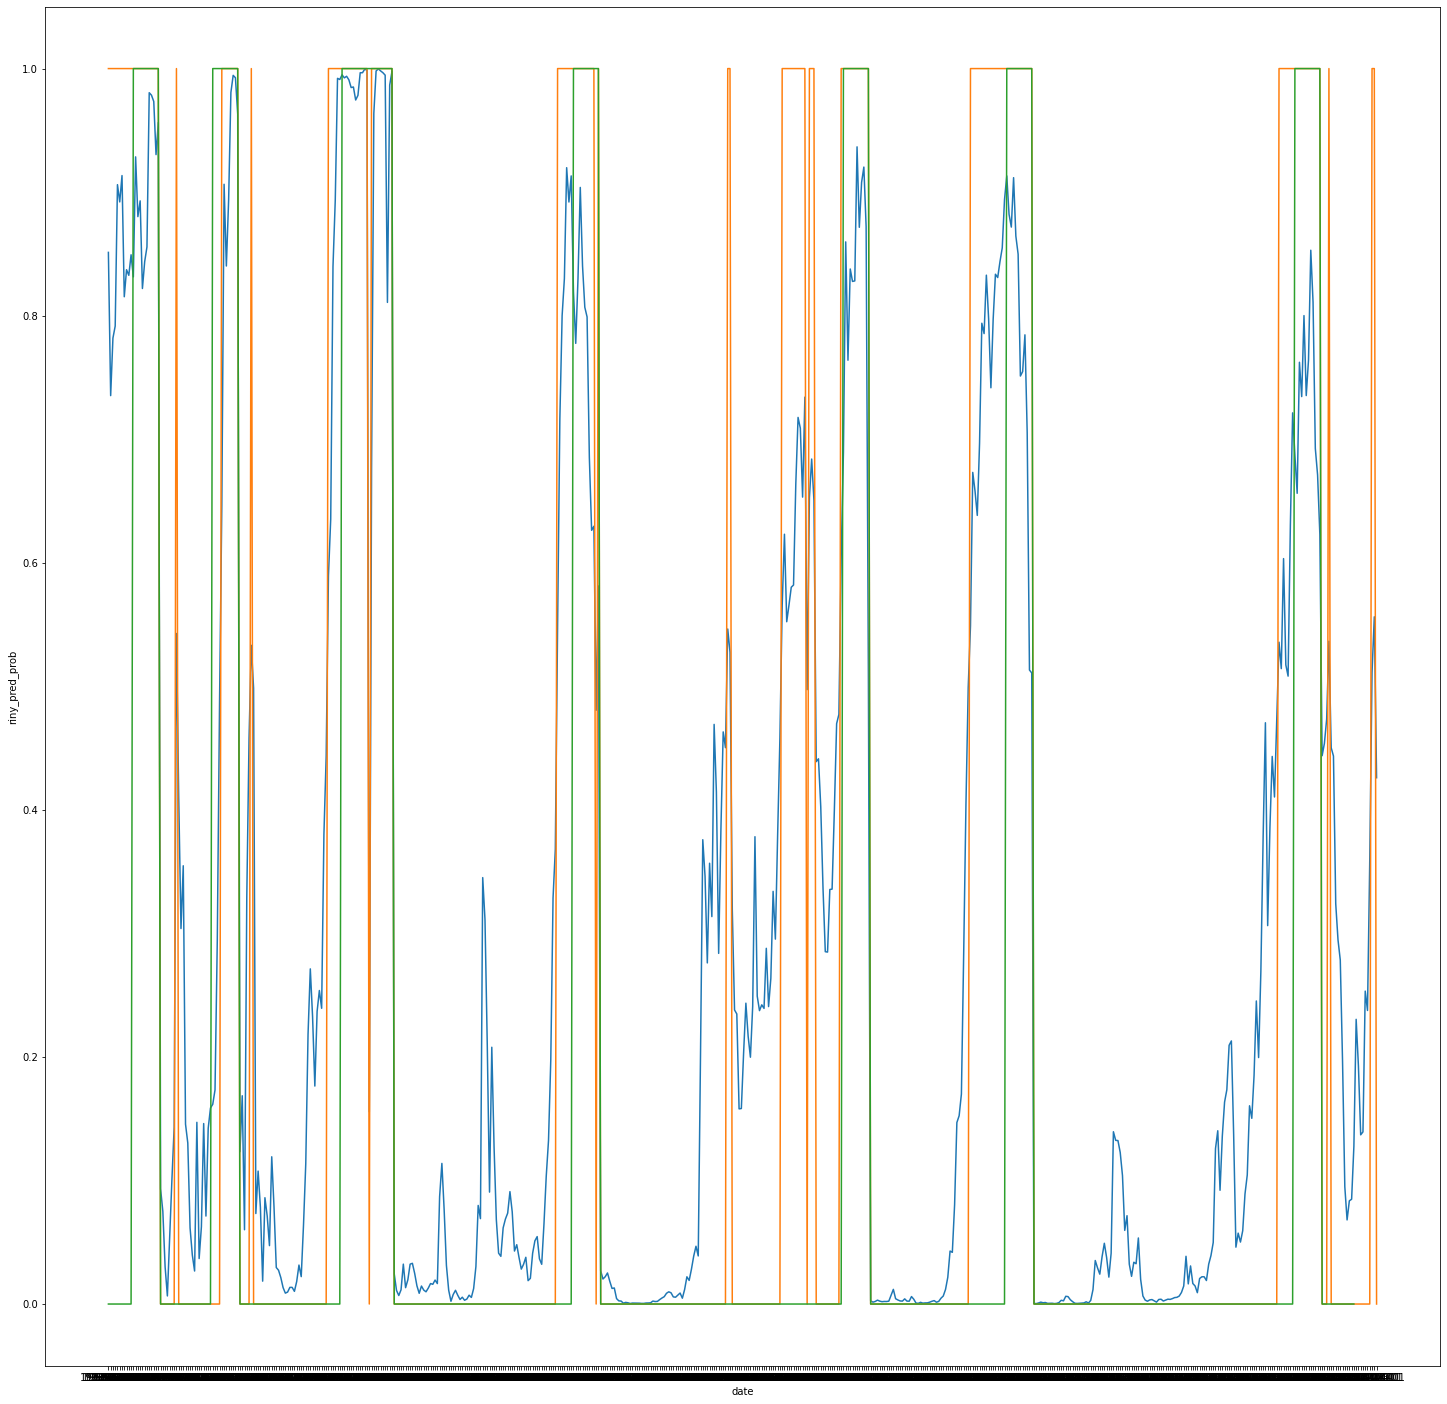

In [48]:
# Distribution of predictions compared to when recessions happen
makePlot(['riny_pred_prob', 'riny_pred_bin','recession_in_next_year'], df=preds_table, horiz_line_height=0.5)

In [ ]:
# Every month right before a recession starts
rec_indices = list(total_data[total_data['date'].isin(recession_starts)].index)
rec_indices = [idx - 1 for idx in rec_indices]
preds_table.filter(items = rec_indices, axis=0)

In [ ]:
# First output: If model predicts a recession, what is the likelihood of it happening
# Second output: If the model gives >= .9 probability of a recession happening, what is the likelihood of it happening
table_copy = total_data.merge(preds_table, on = ['date', 'recession_in_next_year'], how='inner')
print(table_copy[(table_copy['in_recession'] == 0) & 
           (table_copy['riny_pred_bin'] == 1)].recession_in_next_year.value_counts())
print(table_copy[(table_copy['in_recession'] == 0) & 
           (table_copy['riny_pred_prob'] >= 0.9)].recession_in_next_year.value_counts())

In [ ]:
# Same as above second result, but test data only
temp_table = preds_table[preds_table['riny_pred_prob'] >= 0.9].filter(list(X_test.index), axis=0)
temp_table.recession_in_next_year.sum(), len(temp_table)

In [ ]:
# If the model predicts a recession, what is the median number of years until a recession (all data)
table_copy = total_data.merge(preds_table, on = 'date', how='inner')
table_copy[(table_copy['in_recession'] == 0) & 
           (table_copy['riny_pred_bin'] == 1)].years_until_recession.median()

## Predicting Years Until Recession (YUR)
### Linear Regression

In [ ]:
total_data.columns

In [ ]:
scatPlot('yield_diff', 'years_until_recession')

In [51]:
# Create foundation for Years Until Recession (YUR) model

yur_columns = ['date', 'housing_climb_change', '36_mo_cpi_change_all',
       'yield_diff', 'yield_below_zero', 'years_since_recession', 'years_until_recession',
       'recession_in_next_year']

yur_df = total_data[(total_data['in_recession'] == 0) & (~total_data['years_until_recession'].isnull())]
yur_df = yur_df[yur_columns]

yur_sig_features = []
yur_non_sig_features = []

for feature in yur_df.loc[:, ~yur_df.columns.isin(['date', 'recession_in_next_year', 'years_until_recession'])].columns:
    test_sample1 = yur_df[yur_df['recession_in_next_year'] == 1][feature]
    test_sample2 = yur_df[yur_df['recession_in_next_year'] == 0][feature]
    t_stat = ttest_ind(test_sample1, test_sample2, equal_var=False)
    if t_stat.pvalue < 0.05:
        yur_sig_features.append(feature)
    else:
        yur_non_sig_features.append(feature)

print('Significant: ', yur_sig_features)
print('\nNot Significant: ', yur_non_sig_features)

Significant:  ['housing_climb_change', '36_mo_cpi_change_all', 'yield_diff', 'yield_below_zero', 'years_since_recession']

Not Significant:  []


In [52]:
# Create X (features) and y (value) sets
yur_X = yur_df.loc[:, yur_df.columns.isin(yur_sig_features)]
yur_y = yur_df.loc[:, yur_df.columns == 'years_until_recession']
print(yur_y.head(4))
yur_X

   years_until_recession
0               1.917808
1               1.832877
2               1.753425
3               1.668493


,housing_climb_change,36_mo_cpi_change_all,yield_diff,yield_below_zero,years_since_recession
0,0.984412,2.54852,-0.08,1,6.917808
1,0.984412,2.43934,0.21,0,7.002740
2,0.984412,2.74353,0.13,0,7.082192
3,1.437089,2.53815,0.10,0,7.167123
4,1.437089,2.61567,-0.27,1,7.249315
...,...,...,...,...,...
620,-7.022506,0.17869,-0.25,1,10.257534
621,5.800872,0.07116,-0.08,1,10.339726
622,5.800872,0.34649,0.20,0,10.424658
623,5.800872,0.21092,0.23,0,10.506849


In [53]:
# Create train and test splits (Using same train/test as above)

yur_X_train, yur_X_test, yur_y_train, yur_y_test = (yur_X.filter(list(X_train.index), axis=0), 
                                                    yur_X.filter(list(X_test.index), axis=0), 
                                                    yur_y.filter(list(X_train.index), axis=0), 
                                                    yur_y.filter(list(X_test.index), axis=0))
yur_y_train.head(5)

# Standardize variables to create consistent scaling
yur_scaler = preprocessing.StandardScaler().fit(yur_X_train)
yur_X_scaled = yur_scaler.transform(yur_X_train)
yur_X_scaled = pd.DataFrame(data=yur_X_scaled, columns=yur_X_train.columns)

In [54]:
# Fit the model
linreg = LinearRegression()
linreg.fit(yur_X_scaled, yur_y_train)

LinearRegression()

In [55]:
# Print coefficients (based on standardized variables)
coefs_df = pd.DataFrame()
coefs_df['Feature'] = linreg.feature_names_in_
coefs_df['Coefficient'] = linreg.coef_[0]
coefs_df.reindex(coefs_df.Coefficient.abs().sort_values(ascending=False).index)

,Feature,Coefficient
2,yield_diff,1.972089
4,years_since_recession,-0.559479
1,36_mo_cpi_change_all,-0.138836
3,yield_below_zero,0.103963
0,housing_climb_change,0.000268


In [56]:
# Score the model on the test data
yur_y_pred = linreg.predict(yur_scaler.transform(yur_X_test))
print('Test Accuracy: ', round(linreg.score(yur_scaler.transform(yur_X_test), yur_y_test), 3))

# Score the model on the train data
print('Train Accuracy: ', round(linreg.score(yur_X_scaled, yur_y_train),3))

Test Accuracy:  0.628
Train Accuracy:  0.658


In [51]:
# Predictions for the most recent year
present_data['yur_pred'] = linreg.predict(yur_scaler.transform(present_data[yur_sig_features]))
present_data

,date,un_rate,12_mo_unemp_change,median_household_price,pct_house_change_year,housing_climb_change,cpi_change_all,cpi_change_less_food_and_energy,36_mo_cpi_change_all,average_sp_price,...,one_yr_yield,yield_diff,yield_below_zero,years_since_recession,years_until_recession,recession_in_next_year,in_recession,riny_pred_bin,riny_pred_prob,yur_pred
643,2021-08-01,5.2,-3.2,411200.0,21.837037,15.838293,5.20533,3.96186,2.52733,4454.21,...,0.07,1.13,0,1.334247,NaN,NaN,0,0.0,0.218314,3.739373
644,2021-09-01,4.7,-3.2,411200.0,21.837037,15.838293,5.38991,4.03675,3.03473,4445.54,...,0.07,1.24,0,1.419178,NaN,NaN,0,0.0,0.187834,3.858547
645,2021-10-01,4.6,-2.3,423600.0,18.093114,8.432460,6.23694,4.59396,3.70842,4460.71,...,0.09,1.39,0,1.501370,NaN,NaN,0,0.0,0.155001,4.034789
646,2021-11-01,4.2,-2.5,423600.0,18.093114,8.432460,6.82837,4.95263,4.65556,4667.39,...,0.15,1.43,0,1.586301,NaN,NaN,0,0.0,0.165119,3.978061
647,2021-12-01,3.9,-2.8,423600.0,18.093114,8.432460,7.09654,5.47662,5.18132,4674.77,...,0.25,1.18,0,1.668493,NaN,NaN,0,0.0,0.294707,3.462764
648,2022-01-01,4.0,-2.4,428700.0,15.927528,3.526313,7.52593,6.04078,6.02760,4573.82,...,0.40,1.23,0,1.753425,NaN,NaN,0,0.0,0.305193,3.439941
649,2022-02-01,3.8,-2.4,428700.0,15.927528,3.526313,7.91202,6.41574,6.43030,4435.98,...,0.78,1.03,0,1.838356,NaN,NaN,0,0.0,0.443408,3.026891
650,2022-03-01,3.6,-2.4,428700.0,15.927528,3.526313,8.55759,6.43604,6.67764,4391.27,...,0.91,0.81,0,1.915068,NaN,NaN,0,1.0,0.596423,2.598645
651,2022-04-01,3.6,-2.4,428700.0,12.049137,-6.549747,8.22414,6.13369,6.21851,4391.30,...,1.72,0.67,0,2.000000,NaN,NaN,0,1.0,0.670144,2.403307
652,2022-05-01,3.6,-2.2,428700.0,12.049137,-6.549747,8.51641,6.01128,6.70366,4040.36,...,2.10,0.89,0,2.082192,NaN,NaN,0,1.0,0.557456,2.718901


In [52]:
# Add linear predictions to the preds_table
yur_preds_table = total_data.copy()
lin_preds = linreg.predict(yur_scaler.transform(yur_preds_table[yur_sig_features]))
yur_preds_table['yur_pred'] = lin_preds
yur_preds_table = yur_preds_table[['date', 'recession_in_next_year', 'years_until_recession', 'yur_pred']]
preds_table = preds_table.merge(yur_preds_table, on = ['date', 'recession_in_next_year'], how='inner')
preds_table

,date,recession_in_next_year,riny_pred_bin,riny_pred_prob,years_until_recession,yur_pred
0,1968-01-01,0.0,1.0,0.850292,1.917808,1.303845
1,1968-02-01,0.0,1.0,0.776315,1.832877,1.269321
2,1968-03-01,0.0,1.0,0.819066,1.753425,1.079860
3,1968-04-01,0.0,1.0,0.824752,1.668493,1.038312
4,1968-05-01,0.0,1.0,0.904272,1.586301,0.910205
...,...,...,...,...,...,...
555,2022-01-01,NaN,0.0,0.305193,NaN,3.439941
556,2022-02-01,NaN,0.0,0.443408,NaN,3.026891
557,2022-03-01,NaN,1.0,0.596423,NaN,2.598645
558,2022-04-01,NaN,1.0,0.670144,NaN,2.403307


In [53]:
# Analysis of a solo and combined model
linear_under_one = preds_table[preds_table['yur_pred'] <= 1]
print('If Linear <= 1 accuracy: ', len(linear_under_one[linear_under_one['recession_in_next_year'] == 1]) / len(linear_under_one))
print(len(linear_under_one[linear_under_one['recession_in_next_year'] == 1]), len(linear_under_one))
print('If Linear <= 1 and prob >= 0.9 accuracy: ', 
      len(linear_under_one[(linear_under_one['recession_in_next_year'] == 1) & (linear_under_one['riny_pred_prob'] >= 0.9)]) / len(linear_under_one[linear_under_one['riny_pred_prob'] >= 0.9]))
print(len(linear_under_one[(linear_under_one['recession_in_next_year'] == 1) & (linear_under_one['riny_pred_prob'] >= 0.9)]), len(linear_under_one[linear_under_one['riny_pred_prob'] >= 0.9]))



If Linear <= 1 accuracy:  0.847457627118644
50 59
If Linear <= 1 and prob >= 0.9 accuracy:  0.8421052631578947
32 38


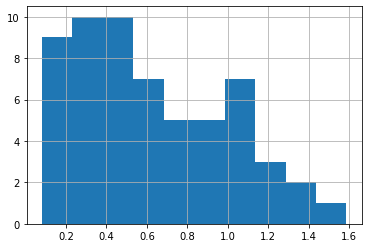

In [54]:
# If the linear model predicts a recession in the next year, how far away is the recession actaully
linear_under_one.years_until_recession.hist()

In [55]:
# residuals data
preds_table['years_off'] = preds_table['years_until_recession'] - preds_table['yur_pred']

-0.3492560343196376
-0.2647603068864829


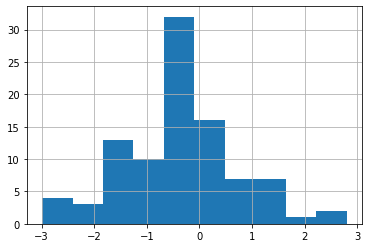

In [56]:
# Typically, if there is a recession in the next year, the model is usally accurate, but often overestimates time
preds_table[preds_table['recession_in_next_year'] == 1].years_off.hist()
print(preds_table[preds_table['recession_in_next_year'] == 1].years_off.mean())
print(preds_table[preds_table['recession_in_next_year'] == 1].years_off.median())

In [57]:
# If logistic says recession, how often does linear agree
print(len(preds_table[(preds_table['riny_pred_bin'] == 1) & (preds_table['yur_pred'] <= 1)]) / len(preds_table[(preds_table['riny_pred_bin'] == 1)]))
print(len(preds_table[(preds_table['riny_pred_bin'] == 1) & (preds_table['yur_pred'] <= 1)]), len(preds_table[(preds_table['riny_pred_bin'] == 1)]))


0.35542168674698793
59 166


In [58]:
# Analysis with combined model
print('If Linear <= 1 and prob >= 0.5 accuracy: ', 
      len(linear_under_one[(linear_under_one['recession_in_next_year'] == 1) & (linear_under_one['riny_pred_bin'] == 1)]) / len(linear_under_one[linear_under_one['riny_pred_bin'] == 1]))
print(len(linear_under_one[(linear_under_one['recession_in_next_year'] == 1) & (linear_under_one['riny_pred_bin'] == 1)]), len(linear_under_one[linear_under_one['riny_pred_bin'] == 1]))


If Linear <= 1 and prob >= 0.5 accuracy:  0.847457627118644
50 59


In [59]:
# Analysis of linear model when expanding range by the mean residual
# When there is a recession, how likely is the linear model to show a close result
print(len(preds_table[(preds_table['recession_in_next_year'] == 1) & (preds_table['yur_pred'] <= 1.58)]) / len(preds_table[(preds_table['recession_in_next_year'] == 1)]))
print(len(preds_table[(preds_table['recession_in_next_year'] == 1) & (preds_table['yur_pred'] <= 1.58)]), len(preds_table[(preds_table['recession_in_next_year'] == 1)]))

0.8105263157894737
77 95


# Summary
##### Note: Values will change as the model is run, these are not dynamic so they will not update with each run. Treat as approximates

## Logistic Model
- Accurate about 87% (140/167) of the time on new data
- When predicting a recession will occur, accurate about 56% (22/39) of the time on new data
- When predicting a recession will not occur, accurate about 97% (118/122) of the time on new data
- When predicting a recession will occur, recession is median 0.9 years away
- When _incorrectly_ predicting a recession will occur, recession is median 1.6 years away
- When there is a recession in the next year, the model will identify it 94% (66/70) of the time 
- If the model gives a 0.9 probability or higher of a recession, accurate about 75% (16/20) of the time

## Linear Model
- Scores about a 65% on the test data
- When predicting recession in <= 1 years, accurate about 89% (51/57) of the time on new data
- Median difference between years until recession and predicted is -0.55 (model tends to overestimate distance)
- Mean difference between years until recession and predicted is -0.29 (model tends to overestimate distance)


## Combined Uses
- When predicting recession in <= 1 years and prob >= 0.5, accurate about 89% (51/57) of the time on new data
- When predicting recession in <= 1 years and prob >= 0.8, accurate about 88% (46/52) of the time on new data
- When predicting recession in <= 1 years and prob >= 0.9, accurate about 86% (37/43) of the time on new data
- When predicting recession in <= 1 years and prob >= 0.95, accurate about 93% (26/28) of the time on new data
- When the logistic model predicts a recession, the linear model agrees just 37% (57/153) of the time on new data

## Main Takeaways / Usability
- If the logistic model says there will not be a recession in the next year, there won't be
- If there is a recession in the next year, the logistic model will most likely spot it
- Pay close attention to economy if logistic model prob hits 0.9 or higher
- If the linear model model predicts less than a year, there will most likely be a recession
- If the combined model @ 0.5, 0.8, or 0.95 says recession, there most likely will be
- Trust linear if prob < 0.92, otherwise trust logistic

*Current Scores do not indicate a recession within the next year*

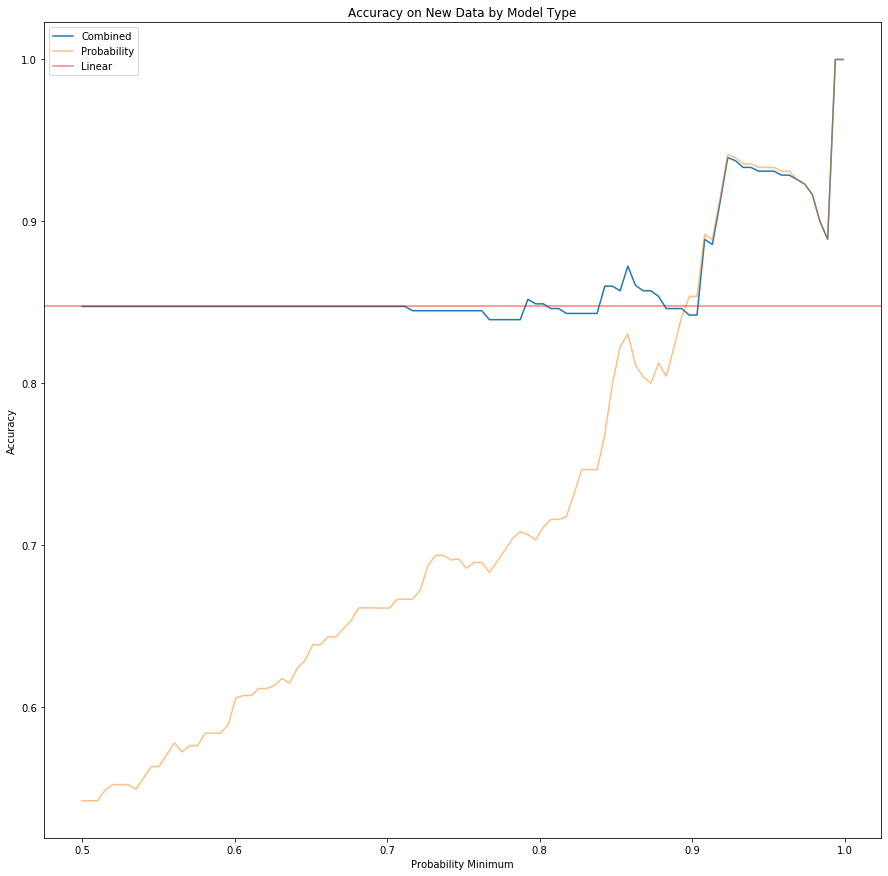

In [60]:
# accuracy chart

combined_pcts = []
prob_pcts = []
num_range = np.linspace(.5,.999, 100)
for i in num_range:
    # combined pcts
    num_correct = len(linear_under_one[(linear_under_one['recession_in_next_year'] == 1) & 
                                       (linear_under_one['riny_pred_prob'] >= i)])
    num_possible = len(linear_under_one[linear_under_one['riny_pred_prob'] >= i])
    pct = num_correct / num_possible
    combined_pcts.append(pct)
    
    # prob pcts
    num_correct_p = len(preds_table[(preds_table['recession_in_next_year'] == 1) & 
                                       (preds_table['riny_pred_prob'] >= i)])
    num_possible_p = len(preds_table[preds_table['riny_pred_prob'] >= i])
    pct_p = num_correct_p / num_possible_p
    prob_pcts.append(pct_p)
    
linear_accuracy = len(linear_under_one[linear_under_one['recession_in_next_year'] == 1]) / len(linear_under_one)

fig, ax = plt.subplots(figsize=(15,15))
sns.lineplot(x=num_range, y = combined_pcts, ax=ax)
sns.lineplot(x=num_range, y = prob_pcts, ax=ax, alpha=0.5)
plt.axhline(y=linear_accuracy, color='red', linestyle='-', alpha=0.5) # add line for linear pct
ax.legend(labels=['Combined', 'Probability', 'Linear'])
ax.set_xlabel('Probability Minimum')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy on New Data by Model Type')
plt.show()

In [61]:
# Value that gives us peak accuracy in a combined scenario
num_range[combined_pcts.index(max(combined_pcts[:-5]))]

0.9233939393939394

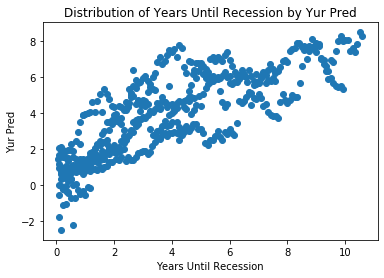

In [62]:
# Predictions vs Actual
fig, ax = plt.subplots(1,1)
ax.scatter(data=preds_table, x='years_until_recession', y='yur_pred')
ax.set_xlabel('years_until_recession'.replace('_', ' ').title())
ax.set_ylabel('yur_pred'.replace('_', ' ').title())
ax.set_title('Distribution of ' + 'years_until_recession'.replace('_', ' ').title() + ' by ' + 'yur_pred'.replace('_', ' ').title())
plt.show()


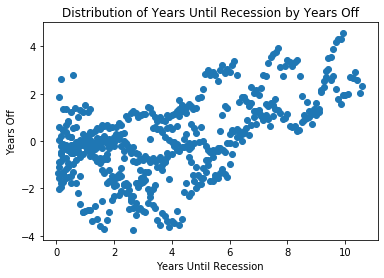

In [63]:
# Residuals
fig, ax = plt.subplots(1,1)
ax.scatter(data=preds_table, x='years_until_recession', y='years_off')
ax.set_xlabel('years_until_recession'.replace('_', ' ').title())
ax.set_ylabel('years_off'.replace('_', ' ').title())
ax.set_title('Distribution of ' + 'years_until_recession'.replace('_', ' ').title() + ' by ' + 'years_off'.replace('_', ' ').title())
plt.show()

In [64]:
# Indicates some pattern not being picked up maybe?
from scipy.stats import linregress
test_df = preds_table[~preds_table['years_off'].isnull()]
linregress(test_df['years_until_recession'].values, 
           test_df['years_off'].values)

LinregressResult(slope=0.32831627953444614, intercept=-1.2341993776434053, rvalue=0.5528935494295515, pvalue=3.695559754479331e-44, stderr=0.0214320444294627)

In [65]:
# As of now would not predict a recession in the next year
present_data

,date,un_rate,12_mo_unemp_change,median_household_price,pct_house_change_year,housing_climb_change,cpi_change_all,cpi_change_less_food_and_energy,36_mo_cpi_change_all,average_sp_price,...,one_yr_yield,yield_diff,yield_below_zero,years_since_recession,years_until_recession,recession_in_next_year,in_recession,riny_pred_bin,riny_pred_prob,yur_pred
643,2021-08-01,5.2,-3.2,411200.0,21.837037,15.838293,5.20533,3.96186,2.52733,4454.21,...,0.07,1.13,0,1.334247,NaN,NaN,0,0.0,0.218314,3.739373
644,2021-09-01,4.7,-3.2,411200.0,21.837037,15.838293,5.38991,4.03675,3.03473,4445.54,...,0.07,1.24,0,1.419178,NaN,NaN,0,0.0,0.187834,3.858547
645,2021-10-01,4.6,-2.3,423600.0,18.093114,8.432460,6.23694,4.59396,3.70842,4460.71,...,0.09,1.39,0,1.501370,NaN,NaN,0,0.0,0.155001,4.034789
646,2021-11-01,4.2,-2.5,423600.0,18.093114,8.432460,6.82837,4.95263,4.65556,4667.39,...,0.15,1.43,0,1.586301,NaN,NaN,0,0.0,0.165119,3.978061
647,2021-12-01,3.9,-2.8,423600.0,18.093114,8.432460,7.09654,5.47662,5.18132,4674.77,...,0.25,1.18,0,1.668493,NaN,NaN,0,0.0,0.294707,3.462764
648,2022-01-01,4.0,-2.4,428700.0,15.927528,3.526313,7.52593,6.04078,6.02760,4573.82,...,0.40,1.23,0,1.753425,NaN,NaN,0,0.0,0.305193,3.439941
649,2022-02-01,3.8,-2.4,428700.0,15.927528,3.526313,7.91202,6.41574,6.43030,4435.98,...,0.78,1.03,0,1.838356,NaN,NaN,0,0.0,0.443408,3.026891
650,2022-03-01,3.6,-2.4,428700.0,15.927528,3.526313,8.55759,6.43604,6.67764,4391.27,...,0.91,0.81,0,1.915068,NaN,NaN,0,1.0,0.596423,2.598645
651,2022-04-01,3.6,-2.4,428700.0,12.049137,-6.549747,8.22414,6.13369,6.21851,4391.30,...,1.72,0.67,0,2.000000,NaN,NaN,0,1.0,0.670144,2.403307
652,2022-05-01,3.6,-2.2,428700.0,12.049137,-6.549747,8.51641,6.01128,6.70366,4040.36,...,2.10,0.89,0,2.082192,NaN,NaN,0,1.0,0.557456,2.718901


In [3]:
datetime.datetime.today().strftime("%Y-%m-%d")

'2022-07-03'

In [6]:
pd.DataFrame(data=pd.date_range('1965-01-01',datetime.datetime.today().strftime("%Y-%m-%d"), 
              freq='MS').strftime("%Y-%m-%d").tolist(), columns=['date'])

,date
0,1965-01-01
1,1965-02-01
2,1965-03-01
3,1965-04-01
4,1965-05-01
...,...
686,2022-03-01
687,2022-04-01
688,2022-05-01
689,2022-06-01
